**Research Methods, Spring 2025**

**Author**: Pablo Estrada

The answers to the homework questions using `Python` are described below. Note that I follow closely the analysis from professor McCarthy and his `R` script. My analysis file is also available in the analysis folder.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfixest as pf
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

# To run in the terminal:
# python data-code/_BuildFinalData.py

# Matplotlib settings
%config InlineBackend.figure_format = 'retina'
blue = '#002878'
gold = '#d2b000'
plt.rcParams.update({
    "text.usetex": True,
})

In [2]:
# Load data
git_path = "https://github.com/imccart/Insurance-Access/raw/refs/heads/master/data/output/"
final_data = pd.read_csv(git_path + "acs_medicaid.txt", sep="\t")

# Create percentage variables
final_data = (
    final_data.assign(
        perc_private=(final_data["ins_employer"] + final_data["ins_direct"]) / final_data["adult_pop"],
        perc_public=(final_data["ins_medicare"] + final_data["ins_medicaid"]) / final_data["adult_pop"],
        perc_ins=(final_data["adult_pop"] - final_data["uninsured"]) / final_data["adult_pop"],
        perc_unins=final_data["uninsured"] / final_data["adult_pop"],
        perc_employer=final_data["ins_employer"] / final_data["adult_pop"],
        perc_medicaid=final_data["ins_medicaid"] / final_data["adult_pop"],
        perc_medicare=final_data["ins_medicare"] / final_data["adult_pop"],
        perc_direct=final_data["ins_direct"] / final_data["adult_pop"],
    )
    .loc[~final_data["State"].isin(["Puerto Rico", "District of Columbia"])]
)

\newpage

**1. Plot the share of the adult population with direct purchase health insurance over time.**

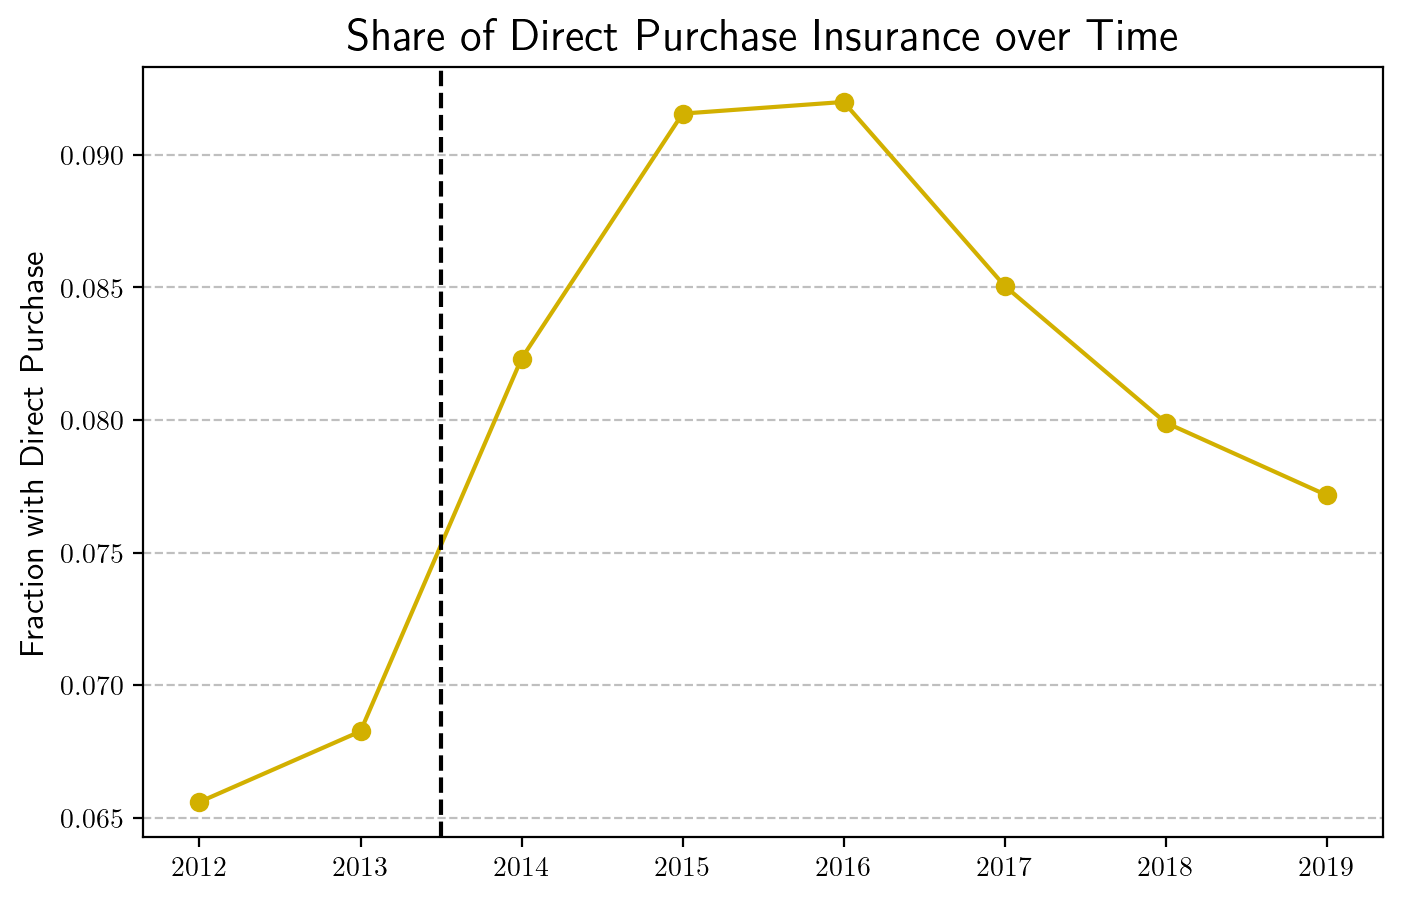

In [3]:
# Plot share of direct purchase
direct_summary = final_data.groupby("year")["perc_direct"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(direct_summary["year"], direct_summary["perc_direct"], marker="o", color=gold)
plt.axvline(x=2013.5, color="black", linestyle="--")
plt.xlabel("")
plt.ylabel("Fraction with Direct Purchase", fontsize=12)
plt.title("Share of Direct Purchase Insurance over Time", fontsize=16)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**3. Plot the share of the adult population with Medicaid over time.**

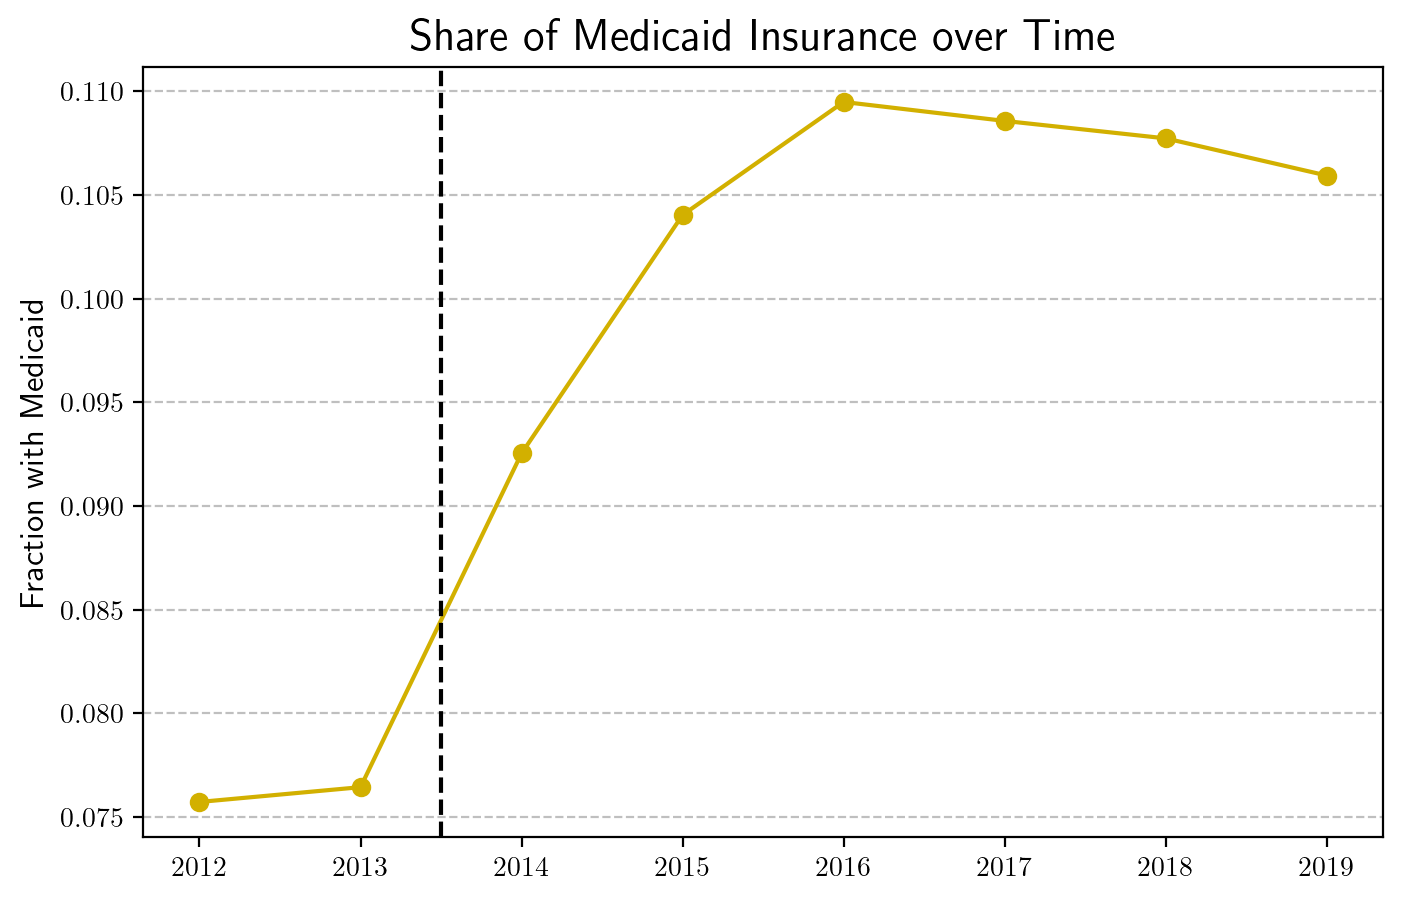

In [4]:
# Plot share of Medicaid
medicaid_summary = final_data.groupby("year")["perc_medicaid"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(medicaid_summary["year"], medicaid_summary["perc_medicaid"], marker="o", color=gold)
plt.axvline(x=2013.5, color="black", linestyle="--")
plt.title("Share of Medicaid Insurance over Time", fontsize=16)
plt.xlabel("")
plt.ylabel("Fraction with Medicaid", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not.**

Drop all states that expanded after 2014.

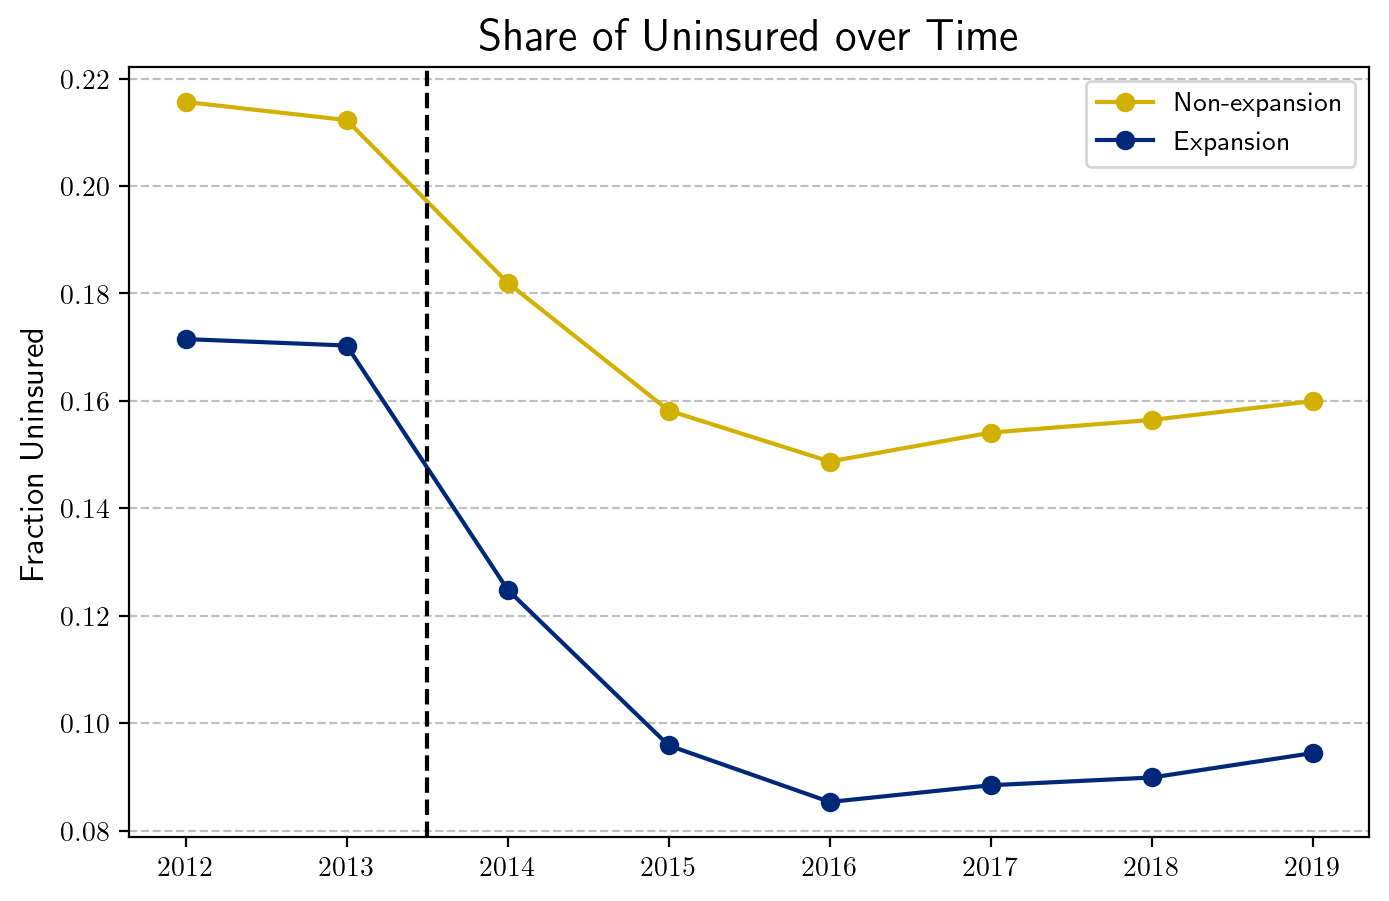

In [5]:
# Plot share uninsured
ins_plot_data = final_data[
    final_data["expand_year"].isna() | (final_data["expand_year"] == 2014)
]
ins_plot_summary = (
    ins_plot_data.groupby(["expand_ever", "year"])["perc_unins"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
for key, grp in ins_plot_summary.groupby("expand_ever"):
    plt.plot(grp["year"], grp["perc_unins"], marker="o", label="Expansion" if key else "Non-expansion", color=blue if key else gold)

plt.axvline(x=2013.5, color="black", linestyle="--")
plt.title("Share of Uninsured over Time", fontsize=16)
plt.xlabel("")
plt.ylabel("Fraction Uninsured", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

\newpage

**5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states.**

Present your results in a basic 2x2 DD table.

In [6]:
# Difference-in-Differences Table
reg_data = (
    final_data.copy()
    .loc[(final_data["expand_year"].isna()) | (final_data["expand_year"] == 2014)]
    .loc[final_data["year"].isin([2012, 2015])]
)

dd_table = (
    reg_data.groupby(["expand_ever", "year"])["perc_unins"]
    .mean()
    .reset_index()
    .pivot(index="expand_ever", columns="year", values="perc_unins")
    .rename(columns={2012: "Pre", 2015: "Post"})
    .reset_index()
)
dd_table["Group"] = dd_table["expand_ever"].map({False: "Non-expansion", True: "Expansion"})
dd_table = dd_table[["Group", "Pre", "Post"]]

def display_markdown_table(df):
    markdown = df.to_markdown(index=False)
    display(Markdown(markdown))

display_markdown_table(dd_table.round(3))

| Group         |   Pre |   Post |
|:--------------|------:|-------:|
| Non-expansion | 0.216 |  0.158 |
| Expansion     | 0.172 |  0.096 |

\newpage

**6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.**

In [7]:
# DD Regression (2014 expansion only)
reg_data = final_data.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"].astype(int)
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# OLS regression without FE
results = []
results.append(
    pf.feols("perc_unins ~ post + expand_ever + treat", data=reg_data)
)

In [8]:
results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type'])
results_table.columns = ['Standard DD']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

display_markdown_table(results_table)

|               | Standard DD       |
|:--------------|:------------------|
| Post 2014     | -0.054*** (0.008) |
| Expand        | -0.043*** (0.009) |
| Post x Expand | -0.020* (0.010)   |
| Num. Obs.     | 344               |
| R2            | 0.508             |

\newpage

**7. Include state and year fixed effects in your estimates.**

In [9]:
# FE regression with state and year fixed effects
results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data)
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table.columns = ['Standard DD', 'TWFE']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

display_markdown_table(results_table)

|               | Standard DD       | TWFE             |
|:--------------|:------------------|:-----------------|
| Post 2014     | -0.054*** (0.008) |                  |
| Expand        | -0.043*** (0.009) |                  |
| Post x Expand | -0.020* (0.010)   | -0.020** (0.007) |
| Num. Obs.     | 344               | 344              |
| R2            | 0.508             | 0.952            |

\newpage

**8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014).**

Are your results different? If so, why?

In [11]:
# DD with time-varying treatment
reg_data2 = final_data.copy()
reg_data2["treat"] = 0
reg_data2.loc[(reg_data2["year"] >= reg_data2["expand_year"]) & (reg_data2["expand_year"].notna()), "treat"] = 1

results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data2)
)

In [12]:
results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table.columns = ['Standard DD', 'TWFE', 'Time-varying Treatment']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')
display_markdown_table(results_table)

|               | Standard DD       | TWFE             | Time-varying Treatment   |
|:--------------|:------------------|:-----------------|:-------------------------|
| Post 2014     | -0.054*** (0.008) |                  |                          |
| Expand        | -0.043*** (0.009) |                  |                          |
| Post x Expand | -0.020* (0.010)   | -0.020** (0.007) | -0.023*** (0.005)        |
| Num. Obs.     | 344               | 344              | 400                      |
| R2            | 0.508             | 0.952            | 0.950                    |

\newpage

**9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.**

In [13]:
# Event Study with constant treatment
reg_data["relative_year"] = (reg_data["year"] - reg_data["expand_year"]).fillna(np.inf)

dynamic_twfe = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                 data=reg_data, vcov={"CRV1": "State"})

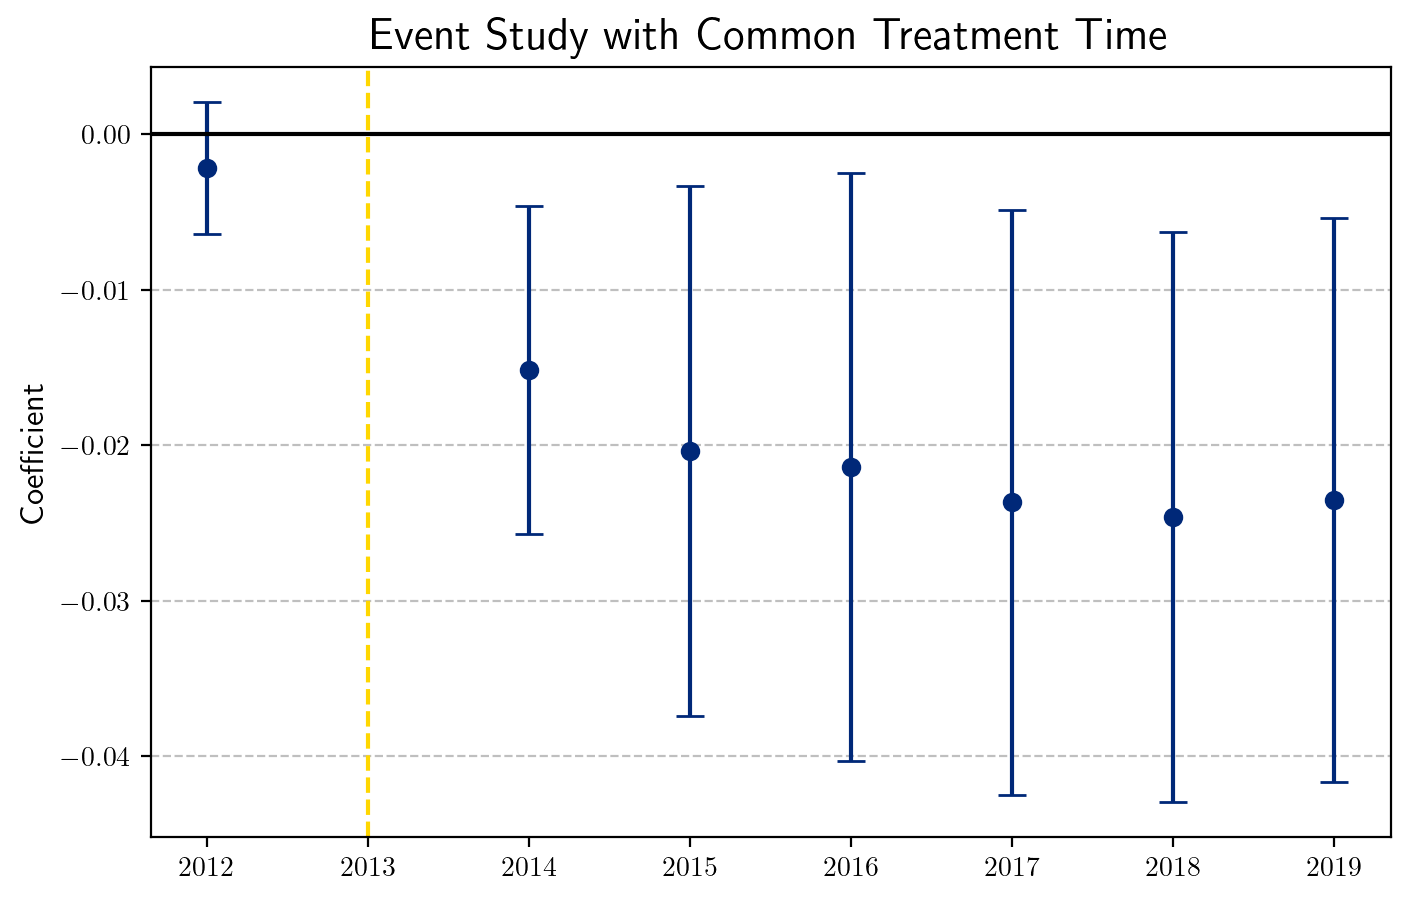

In [14]:
plt.figure(figsize=(8, 5))
joint_ci = dynamic_twfe.coef() - dynamic_twfe.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(2012, 2020), 1), dynamic_twfe.coef(), 
             yerr=joint_ci, fmt='o', color=blue, capsize=5)
plt.axvline(x=2013, color="gold", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Common Treatment Time", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\newpage

**10. Repeat part 9 but again include states that expanded after 2014.**

In [15]:
# ATE Q6: Event Study with time-varying treatment
reg_data2["relative_year"] = (reg_data2["year"] - reg_data2["expand_year"]).fillna(np.inf)
reg_data2["relative_year"] = reg_data2["relative_year"].clip(lower=-4)

dynamic_twfe2 = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                  data=reg_data2, vcov={"CRV1": "State"})

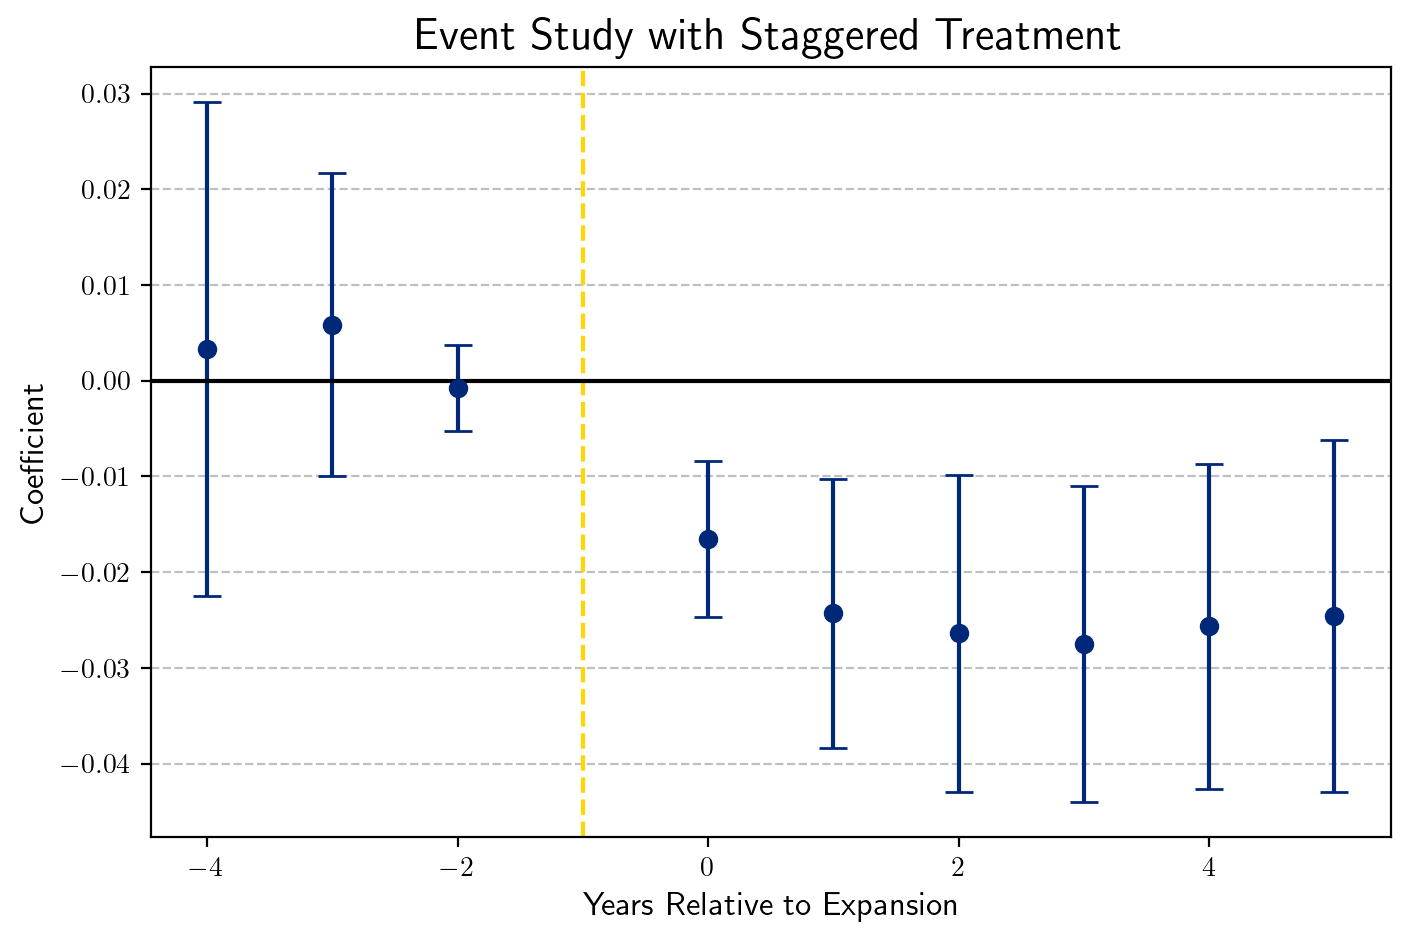

In [16]:
plt.figure(figsize=(8, 5))
joint_ci2 = dynamic_twfe2.coef() - dynamic_twfe2.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(-4, 6), 3), dynamic_twfe2.coef(), 
             yerr=joint_ci2, fmt='o', color=blue, capsize=5)
plt.axvline(x=-1, color="gold", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Staggered Treatment", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.xlabel("Years Relative to Expansion", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# jupyter nbconvert --to pdf --no-input --output estrada-p-hwk5-1.pdf "Homework 5.ipynb"

In [30]:
# Using the U.S. Census Bureau API with Python
# https://medium.com/@mcmanus_data_works/using-the-u-s-census-bureau-api-with-python-5c30ad34dbd7
import requests

# My API key
MY_KEY = 'f7f0680088fb4a7cd81c3dc35098aef0e13eab7d'
usr_key = f"&key={MY_KEY}"

# Census API URL
host = 'https://api.census.gov/data'
year = '/2018'
dataset_acronym = '/acs/acs1'
g = '?get='
variables = 'NAME,B01001_001E'
location = '&for=us:*'

#Put it all together in one f-string:
query_url = f"{host}{year}{dataset_acronym}{g}{variables}{location}{usr_key}"

# Use requests package to call out to the API
response = requests.get(query_url)

# Convert the Response to text and print the result
# print(response.text)